In [1]:
import numpy as np
import sys
from io import BytesIO
from flask import Flask, render_template, send_file, make_response, request

import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

from interp3d import interp_3d
from scipy.interpolate import RegularGridInterpolator

/opt/miniconda3/envs/Astro/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
sys.path.insert(0, '/Users/miguel/Develop/python_utils/')
sys.path.insert(0, '/Users/miguel/Develop/python_utils/SDSS/')

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from SDSS_viewer.compute import *
from idl import *

***
***
***

### Read density field map

In [49]:
PATH = '/Users/miguel/Projects/SDSS_density_explorer/Data/'
FILE_DENS = 'DR13_D_all_random_boundary.ENS-256.SIG-0.5.fvol'
FILE_MASK = 'DR13_D_all.3D_MASK.bvol'

#--- Read volume as global variable
print('>>> Reading density field...')
vol_den = read_fvolume(PATH + FILE_DENS)
vol_den = np.asfarray( vol_den, dtype='float' )

print('>>> Reading mask...')
mask = read_bvolume(PATH + FILE_MASK)

weight = read_bvolume(PATH + 'weights.fvol')

#--- Divide by mean density
mean_den = np.mean( vol_den.compress((mask != 0).flat) )
vol_den /= mean_den

#--- Mask density field
vol_den *= mask
mask = 0

>>> Reading density field...
>>> Reading volume of size: 1024 512 512
>>> Reading mask...
>>> Reading volume of size: 1024 512 512
>>> Reading volume of size: 1024 512 512


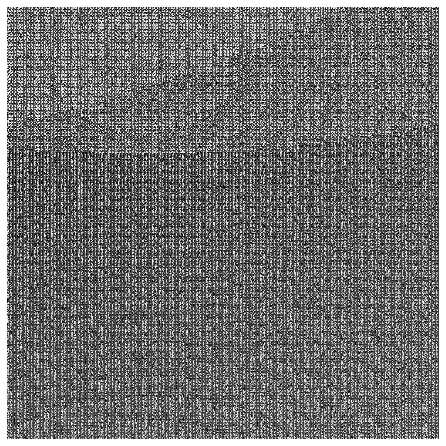

In [50]:
tvscale( weight[511,:,:] )

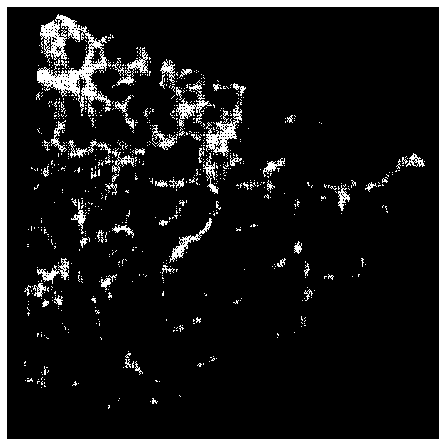

In [48]:
tvscale( (vol_den[511,:,:] > 3)**0.1)

In [40]:
np.mean(kk)

4701848.543322342

### Define map properties

In [ ]:
mapp = {'x0':0.5, 'y0':0.0, 'z0':0.04, 'max_l':1024, 'H_o':73.0, 'c_l':299792.458}

### Read MANGA sample

In [ ]:
FILE_CSV = '/Users/miguel/Science/Hector/Data/BSF_v5.1.csv'
manga = np.genfromtxt(FILE_CSV, delimiter=',', skip_header=1, dtype=None, encoding='utf-8')

### This is the target galaxy

In [ ]:
target = {'ra':manga[0][1], 'dec':manga[0][2], 'z':manga[0][3]}
target

***

In [ ]:
tvscale(vol_den[255,:,:] > 10000000)

***

In [ ]:
x = np.linspace(0,1024,1024)
y = np.linspace(0,511,512)
z = np.linspace(0,511,512)

X,Y,Z = np.meshgrid(x,y,z,indexing='ij')
interp = interp_3d.Interp3D(vol_den, x,y,z)

In [ ]:
#--------------------------------------------
#  Redshift (sky) projection (RA,DEC)
#--------------------------------------------

ra_delta  = 30
dec_delta = 30

ima = get_reds_slice_simple(vol_den, interp, target, 
                            ra_delta=ra_delta, dec_delta=dec_delta, n_ra=64, n_dec=64,mapp=mapp)

x1 = -ra_delta/2
x2 =  ra_delta/2
y1 = -dec_delta/2
y2 =  dec_delta/2

fig, ax = plt.subplots(1)
plt.rcParams['figure.figsize'] = [6, 6]
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$\delta$')
plt.imshow(ima,interpolation="none", origin='lower',cmap='terrain',extent=[x1,x2,y1,y2])

plt.show()



from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots()
plt.rcParams['figure.figsize'] = [6, 6]

ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$\delta$')


divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.2)

im = ax.imshow(ima, cmap='terrain',extent=[x1,x2,y1,y2])

fig.colorbar(im, cax=cax, orientation='vertical')
plt.show()

In [ ]:
#--------------------------------------------
#  Right Ascencion slice (DEC,z)
#--------------------------------------------


dec_delta=30

c_l = 300000.0
z_delta = 0.02

print(manga[0][3])
ima = get_ra_slice(vol_den=vol_den, interp=interp, target=target, 
                   dec_delta=dec_delta, reds_delta=z_delta, n_dec=128, n_reds=128, mapp=mapp)

x1 = -dec_delta/2
x2 =  dec_delta/2
y1 = -(z_delta/2)*c_l
y2 =  (z_delta/2)*c_l
fig, ax = plt.subplots(1)
plt.rcParams['figure.figsize'] = [6, 8]
ax.set_xlabel(r'$\delta$')
ax.set_ylabel('km/s')
plt.imshow(ima,interpolation="none", origin='lower',cmap='terrain',extent=[x1,x2,y1,y2],aspect='auto')
plt.show()

In [ ]:
#--------------------------------------------
#  Declination slice (RA,z)
#--------------------------------------------


ra_delta = 30

c_l = 300000.0
z_delta = 0.02

ima = get_dec_slice(vol_den, interp, target=target, 
                            ra_delta=ra_delta, reds_delta=z_delta, n_ra=512, n_reds=512, mapp=mapp)
    
x1 = -ra_delta/2
x2 =  ra_delta/2
y1 = -(z_delta/2)*c_l
y2 =  (z_delta/2)*c_l

fig, ax = plt.subplots(1)
plt.rcParams['figure.figsize'] = [4,4]
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel('km/s')
plt.imshow(ima,interpolation="none", origin='lower',cmap='terrain',extent=[x1,x2,y1,y2],aspect='auto')
plt.show()

In [ ]:
ra  = (12 + 36.0/60 + 59.34697/60.0/60.0)/24*360
dec = 14 + 19/60 + 49.1585/60.0/60.0
z = 0.082557

print(ra,dec,z)

In [ ]:
#--------------------------------------------
#  Sphere around galaxy
#--------------------------------------------

for i in range(1,5):

    radius = i*2.5
    print('radius = ', radius)
    
    ima = get_sphere_simple(vol_den, interp, target=target, 
                            n_lon=256, n_lat=128, radius=radius, mapp=mapp)

    x1 = 0
    x2 = 360
    y1 = -90
    y2 = 90
    fig, ax = plt.subplots(1)
    plt.rcParams['figure.figsize'] = [8,4] 
    ax.set_xlabel('lat')
    ax.set_ylabel('lon')
    plt.imshow(ima,interpolation="none", origin='lower',cmap='terrain',extent=[x1,x2,y1,y2])
    plt.show()